# Goals: rebuild Random Forest Regression from scratch

Use only python and some basic numpy function (numpy slicing, np.mean, np.nonzero)

Produce comparable results to Sklearn Ramdon Forest on some regression dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model.utils import draw_tree
from model.metrics import *
np.random.seed(42)

# Generate a random-generated dataset

In [9]:
nrows=20
df = pd.DataFrame(np.random.randint(1,10,(nrows,3)),columns=['f0','f1','y'])
print(df.head())
y = df.y.values
df.drop('y',axis=1,inplace=True)

   f0  f1  y
0   2   9  5
1   6   4  7
2   9   7  1
3   1   9  9
4   4   9  3


# Check whether my RF splits are the same as sklearn Random Forest's

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

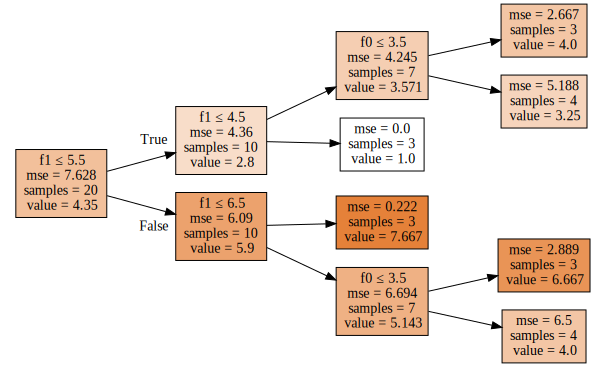

In [10]:
# sklearn RF split
rf = RandomForestRegressor(n_estimators=1,max_depth=3,bootstrap=False,min_samples_leaf=3)
rf.fit(df,y)
draw_tree(rf.estimators_[0], df, precision=3)

In [11]:
from model.random_forest import RandomForest

In [20]:
# My RF split
ens = RandomForest(df, y,1, nrows)
tree = ens.trees[0]

In [22]:
tree

Sample size: 20. Pred value: 4.35. Loss: 7.628
Best split from feature 1 at value 5

In [23]:
tree.lhs_tree

Sample size: 10. Pred value: 2.80. Loss: 4.360
Best split from feature 1 at value 4

In [24]:
tree.rhs_tree

Sample size: 10. Pred value: 5.90. Loss: 6.090
Best split from feature 1 at value 6

In [27]:
print(tree.lhs_tree.lhs_tree)
print(tree.lhs_tree.rhs_tree)

Sample size: 7. Pred value: 3.57. Loss: 4.245
Best split from feature 0 at value 2
Sample size: 3. Pred value: 1.00. Loss: 0.000



In [28]:
print(tree.rhs_tree.lhs_tree)
print(tree.rhs_tree.rhs_tree)

Sample size: 3. Pred value: 7.67. Loss: 0.222

Sample size: 7. Pred value: 5.14. Loss: 6.694
Best split from feature 0 at value 3


My RF regressor is able to produce the exact split like sklearn RF

# Benchmarking on random-generated dataset

In [29]:
nrows=1000
ncols=10
df = pd.DataFrame(np.random.randint(1,10,(nrows,ncols)))
y = df[ncols-1].values
df.drop(ncols-1,axis=1,inplace=True)

In [32]:
rf = RandomForestRegressor(n_estimators=5,bootstrap=False,min_samples_leaf=3)
rf.fit(df,y)

rf_pred = rf.predict(df)
print(f'MSE score: {MSE(y,rf_pred)}')
print(f'R2 score: {metrics.r2_score(y,rf_pred)}')

MSE score: 2.0772524444444445
R2 score: 0.6952187072704108


In [33]:
tb = RandomForest(df, y, n_trees=5, sample_sz=nrows)
tb_pred = tb.predict(df)
print(f'MSE score: {metrics.mean_squared_error(y,tb_pred)}')
print(f'R2 score: {metrics.r2_score(y,tb_pred)}')

MSE score: 2.1058883111111113
R2 score: 0.6910171589778858


# Benchmarking: Boston housing dataset

The dataset for this project originates from the UCI Machine Learning Repository. The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:

- 16 data points have an 'MEDV' value of 50.0. These data points likely contain missing or censored values and have been removed.
- 1 data point has an 'RM' value of 8.78. This data point can be considered an outlier and has been removed.
- The features 'RM', 'LSTAT', 'PTRATIO', and 'MEDV' are essential. The remaining non-relevant features have been excluded.
- The feature 'MEDV' has been multiplicatively scaled to account for 35 years of market inflation.

In [34]:
housing = pd.read_csv('data/housing.csv')
print(housing.shape)
housing.head()

(489, 4)


,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


In [35]:
y = housing.MEDV.values
X = housing.drop('MEDV',axis=1)

In [36]:
from sklearn.model_selection import train_test_split
def get_train_val(X,y):
    X_train,X_val,y_train,y_val =  train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train.reset_index(drop=True),X_val.reset_index(drop=True),y_train,y_val

In [37]:
X_train,X_val,y_train,y_val = get_train_val(X,y)

### sklearn Random Forest

In [81]:
rf = RandomForestRegressor(n_estimators=15,max_features=0.8,bootstrap=False,min_samples_leaf=10)
rf.fit(X_train,y_train)

rf_train_pred = rf.predict(X_train)
rf_val_pred = rf.predict(X_val)

print(f'MSE train score: {metrics.mean_squared_error(y_train,rf_train_pred)}')
print(f'MSE val score: {metrics.mean_squared_error(y_val,rf_val_pred)}')
print(f'R2 train score: {metrics.r2_score(y_train,rf_train_pred)}')
print(f'R2 val score: {metrics.r2_score(y_val,rf_val_pred)}')

MSE train score: 3100445764.0763206
MSE val score: 3219791806.9669237
R2 train score: 0.8905847020820434
R2 val score: 0.8534966571980468


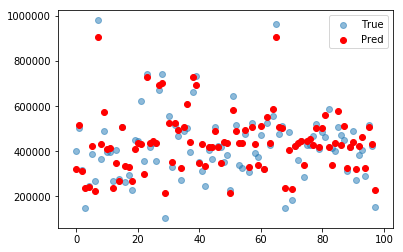

In [82]:
plt.scatter(range(0,len(y_val)),y_val,alpha=0.5,label='True')
plt.scatter(range(0,len(rf_val_pred)),rf_val_pred,c='r',label='Pred')
plt.legend()
plt.show()

## My Random Forest

In [86]:
X_train.shape[0]

391

One possible thing I can tune here but not in sklearn Random Forest is the size of data subset for each tree (sample_sz)

In [134]:
%%time
tb = RandomForest(X_train, y_train, n_trees=20, sample_sz=150,min_leaf=4,max_features=1)
tb_train_pred = tb.predict(X_train)
tb_val_pred = tb.predict(X_val)
print(f'MSE train score: {metrics.mean_squared_error(y_train,tb_train_pred)}')
print(f'MSE val score: {metrics.mean_squared_error(y_val,tb_val_pred)}')
print(f'R2 train score: {metrics.r2_score(y_train,tb_train_pred)}')
print(f'R2 val score: {metrics.r2_score(y_val,tb_val_pred)}')

MSE train score: 3372489559.856298
MSE val score: 3477783760.5038266
R2 train score: 0.8809842267868835
R2 val score: 0.8417577977080082
Wall time: 221 ms


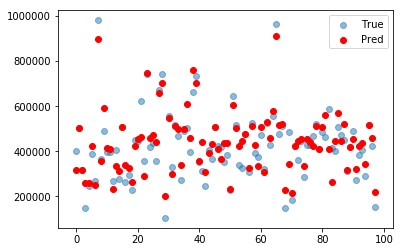

In [135]:
plt.scatter(range(0,len(y_val)),y_val,alpha=0.5,label='True')
plt.scatter(range(0,len(tb_val_pred)),tb_val_pred,c='r',label='Pred')
plt.legend()
plt.show()

Able to draw a comparable result to sklearn Random Forest

In [136]:
# Take a look at prediction differences b/t 2 models
pd.Series(abs(rf_val_pred-tb_val_pred)).describe()

count       98.000000
mean     14091.515729
std      13859.367850
min        255.530303
25%       5550.851892
50%      10468.054696
75%      18474.863616
max      75983.185499
dtype: float64

# Calculate feature importance

Feature importance will be calculated by using **permutation importance**. There is an argument which is mentioned in this [doc](http://parrt.cs.usfca.edu/doc/rf-importance/index.html#3) that feature importance calculated in sklearn is misleading. SKlearn used **mean decrease in impurity (gini improtance)**, which does not always give an accurate picture of importance. 

On the other hand, **permutation importance** is calculated as follows: Record a baseline accuracy (classifier) or R2 score (regressor) by passing a validation set or the out-of-bag (OOB) samples through the Random Forest. Permute the column values of a single predictor feature and then pass all test samples back through the Random Forest and recompute the accuracy or R2. The importance of that feature is the difference between the baseline and the drop in overall accuracy or R2 caused by permuting the column. This is more expensive to calculate, but results are more reliable

In [138]:
from model.utils import permutation_importances

In [139]:
??permutation_importances

## Feature importance from Sklearn's RF model


In [143]:
def metric(rf,X,y):
    y_pred = rf.predict(X)
    return metrics.r2_score(y,y_pred)

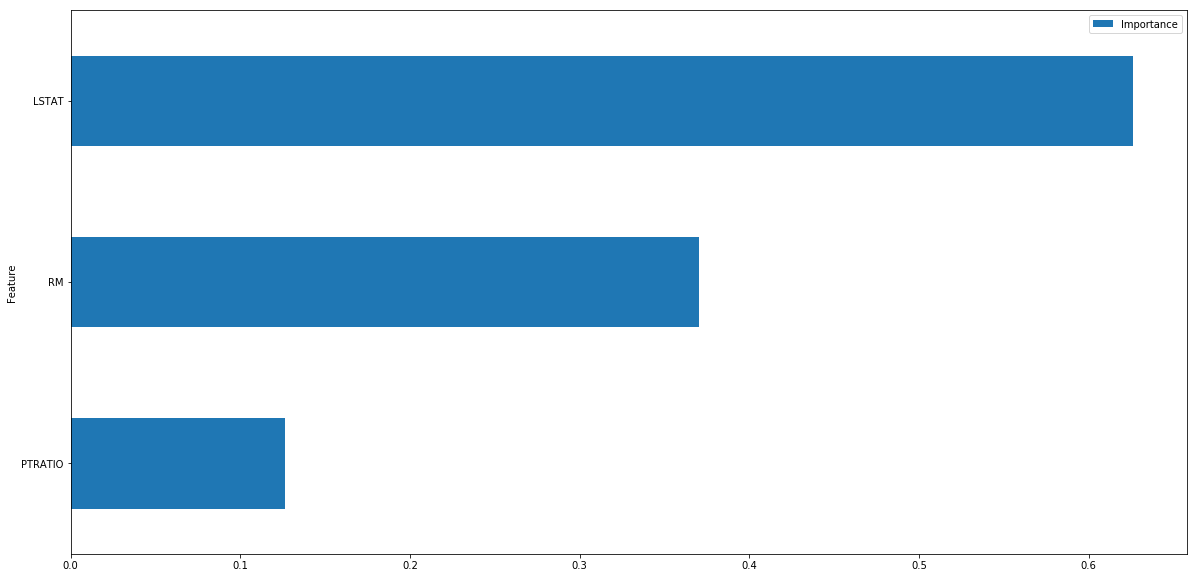

In [144]:
fea_imp_df = permutation_importances(rf,X_val,y_val,metric,False)

## Feature importance from 'scratch' RF

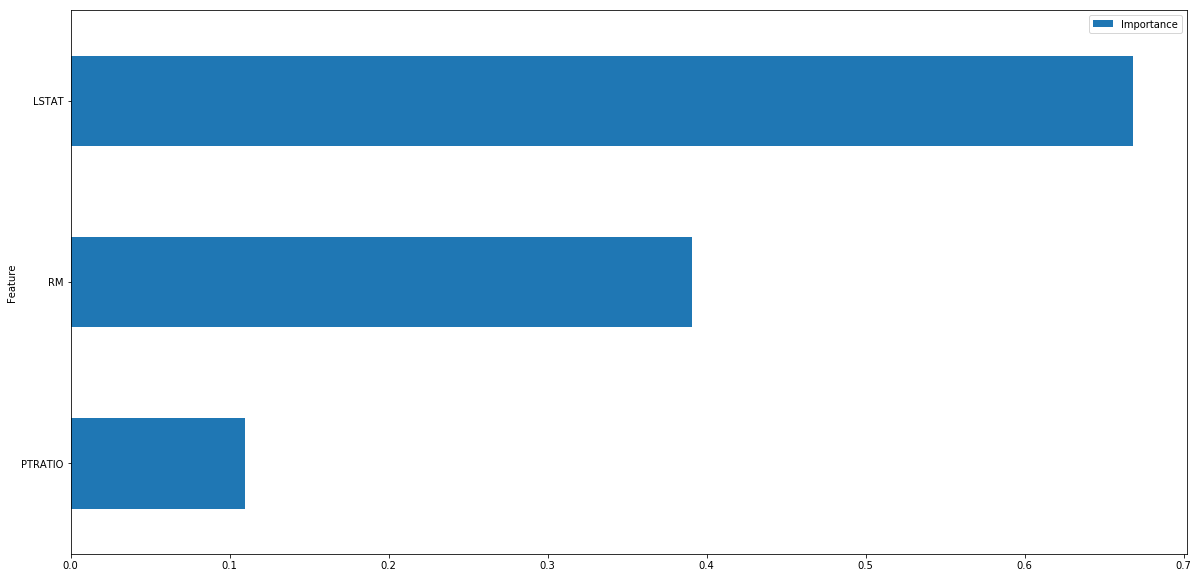

In [145]:
fea_imp_df = permutation_importances(tb,X_val,y_val,metric,False)